# Извлечение данных из коллекции новостных текстов

Данные расположены  [в файле data/news.tar.gz](data/news.tar.gz). С некоторых новостных сайтов был загружен архив новостей а  несколько лет, причем каждая новость принаделжит к какой-то рубрике: `science`, `style`, `culture`, `life`, `economics`, `business`, `travel`, `forces`, `media`, `sport`
    

В каждой строке файла содержится метка рубрики, заголовок новостной статьи и сам текст статьи, например:

        sport <tab> Сборная Канады по хоккею разгромила чехов <tab> Сборная Канады по хоккею крупно об...

С помощью [Yargy](https://github.com/natasha/yargy) или [Томита-парсера](https://github.com/yandex/tomita-parser) извлеките данные, которые можно описать структурой вида:


```python
@dataclass
class Entry:
    name: str
    birth_date: Optional[str]
    birth_place: Optional[str]
```

**NOTE**: Если будет проблемы с `FileNotFoundError` и отображением деревьев, то мне помогло вот [это](https://giters.com/natasha/yargy/issues/82), а именно установка [версии 9.0.0](https://graphviz.org/download/) 

Найдем несколько примеров из файла

- Эстерхази родился в венгерской столице в 1950 году
- Иосиф Кобзон родился в городе Часов Яр Донецкой области
- Гвасалия родился в Грузии
- Трэмиел родился в 1928 году в Польше
- Салман Рушди родился в Мумбаи
- Он родился в Польше 11 сентября 1865 года
- Ребенок родился в Калифорнии 25 декабря
- принц Джордж, родился в 2013 году
- Мейстон родился 1935 году
- Дмитрий Чернявский родился в Артемовске 5 марта 1992 года
- Эли Визель родился в 1928 году в еврейской семье на севере Румынии.
- Миллиардер родился в 1938 году в Лондоне
- Юрий Яковлев родился в Москве в 1928 году
- Смирнов  18 декабря 1937 года в городе Калининграде (ныне Королев) Московской области.
- Патрик родился в Бронксе в 1990 году,
- Николай Караченцов родился 27 октября 1944 года в Москве в семье
- Орест I (он же Орест Федорович Карелин-Романишин-Русин) родился в 1950 году во Львове.
- Головко родился 24 ноября 1932 года в городе Бар (Винницкая область Украины)
- Том Роу (полное имя Томас Джон Роу - Thomas John Rowe) родился в 1956 году в Массачусетсе, США.
- Игорь Доценко родился в 1953 году в Хмельницкой области Украины.
- Энгельбарт родился в 1925 году в США
- Ежата Джордж, Александр и Луи родились в зоопарке 22 июля 2013 года.
- Блю Айви Картер родилась 7 января в Нью-Йорке

**NOTES**

- Нам нужно, чтобы было именно имя, и опционально дата/место. То есть `Салман Рушди родился в Мумбаи` подойдёт, и `Мейстон родился 1935 году` подойдёт, и `Юрий Яковлев родился в Москве в 1928 году` тоже подойдёт
- Хочется искать не только *Имя-Фамилия*, но и просто *Имя* или просто *Фамилия* (например: `Патрик родился в Бронксе в 1990 году`). Но у меня не получилось
- Будем также игнорировать скобки, например `Орест I (он же Орест Федорович Карелин-Романишин-Русин) родился в 1950 году во Львове.` - подойдёт.
- Есть много составных мест, например, `в Хмельницкой области Украины`, `в Массачусетсе, США.` и др. Хотелось бы их тоже находить полностью.
- Даты тоже разные, есть просто год, есть полные, есть только день и месяц, давайте находить и те, и те, и те и может ещё какие-нибудь

In [1]:
from yargy import Parser, rule, and_, or_, not_
from yargy.predicates import gram, is_capitalized, normalized, dictionary,  gte, lte
from yargy.pipelines import morph_pipeline
from yargy.interpretation import fact, attribute
from yargy.relations import gnc_relation


Факты:

In [2]:
Entry = fact(
    "Entry",
    ["name", "birth_place", "birth_date"]
)

Name = fact(
    "Name",
    ["first", "second", "last", "patronymic"]
)

Date = fact(
    "Date",
    ["day", "month", "year"]
)

Place = fact(
    "Place",
    [attribute('toponym').repeatable()]
)

Начнём с имени (учтём дефис)

In [3]:
JUST_NAME = rule(
    or_(
        rule(gram("Name")),
        rule(
           gram("Name"), "-", or_( # Сергей-Емеля, Иван-царевич
               is_capitalized()
           )
        )
    )
)


# alternative 
# JUST_NAME = rule(
#     or_(
#         rule(is_capitalized()),
#         rule(
#            is_capitalized(), "-", or_(  # Сергей-Емеля, # Иван-царевич
#                is_capitalized(),
#                not_(is_capitalized())
#             #    gram("NOUN"), 
#             #    gram("ADJF") 
#                # ...
#            )
#         )
#     )
# )


Сразу словим интересный баг - *март* в падеже винительном *марта* распознается как женское имя Марта))

['Дмитрий']


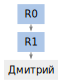

['марта']


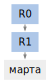

In [4]:

parser = Parser(JUST_NAME)
for match in parser.findall("Дмитрий Чернявский родился в Артемовске 5 марта 1992 года"):
    print([_.value for _ in match.tokens])
    display(match.tree.as_dot)

Фикс:

In [5]:
JUST_NAME = rule(
    or_(
        rule(and_(
            gram("Name"),
            is_capitalized()
        )),
        rule(
            gram("Name"),
            rule(
                "-",  # Сергей-Емеля, Иван-царевич
                is_capitalized()
            ).repeatable()
        )
    )
)


In [6]:
parser = Parser(JUST_NAME)
for match in parser.findall("Дмитрий Чернявский родился в Артемовске 5 марта 1992 года"):
    print([_.value for _ in match.tokens])

['Дмитрий']


Но что-то с этим *gram("Name")* всё-таки не то...

In [7]:
G = rule(
    gram("Name")
)
parser = Parser(G)
l = [
    "Ало избушке Москва кот Живет. Петя Петров, из про над На Ананас, про Гриб В дыре.  в марте",
    "В",
    "Аня"
]
for text in l:

    for match in parser.findall(text):
        print([_.value for _ in match.tokens])
        # display(match.tree.as_dot)

['Ало']
['Петя']
['Петров']
['из']
['В']
['марте']
['В']
['Аня']


Почему-то добавляет и предлоги, притом не все...

Попробуем законтрить

In [8]:
G = rule(
    and_(
        gram("Name"),
        not_(gram("PREP"))
    )
)
parser = Parser(G)
l = [
    "Ало избушке Москва кот Живет. Петя Петров, из про над На Ананас, про Гриб В дыре в марте.",
    "В",
    "Аня"
]
for text in l:

    for match in parser.findall(text):
        print([_.value for _ in match.tokens])
        # display(match.tree.as_dot)

['Ало']
['Петя']
['Петров']
['марте']
['Аня']


Ну что ж, ладно... В интернетах ничего дельного по этому поводу не нашёл

Итого у нас JUST_NAME:

In [9]:
FIXED_NAME = rule(
    and_(
        gram("Name"),
        is_capitalized(),
        not_(gram("PREP"))
    )
)


JUST_NAME = rule(
    or_(
        FIXED_NAME,
        rule(
            FIXED_NAME,
            rule(
                "-",  # Сергей-Емеля, Иван-царевич
                is_capitalized()
            ).repeatable()
        )
    )
)

Теперь фамилия

Петр I, Патрик III

In [10]:
TITULS = dictionary(["I","II","III","IV","V","VI","VII","VIII","IX","XI","XII","XII","XIV","XV"])

In [11]:
SURNNAME = rule(
    or_(
        rule("Surn"),
        rule(TITULS)
    )
)


NO_PREP_SURN = rule(
    and_(
        is_capitalized(),
        not_(gram("PREP"))
    )  
)
# alternative
SURNNAME_OVERKILL = rule(
    or_(
        NO_PREP_SURN,
        rule(
           NO_PREP_SURN, "-", or_(  # Нагиев-младший, Муравьев-Апостол
               not_(is_capitalized()),
               is_capitalized()
            #    gram("NOUN"), 
            #    gram("ADJF") 
               # ...
           )
        ),
        rule(TITULS)
    )
)


И отчество на всякий случай

In [12]:
PATR = rule(
    gram("Patr")
)

Склеим всё вместе

In [13]:
gnc = gnc_relation()

NAME = rule(
    or_(
        # name is there
        rule(
            JUST_NAME.match(gnc).interpretation(Name.first.inflected()),
            SURNNAME_OVERKILL.match(gnc).interpretation(Name.last.inflected()),
            PATR.match(gnc).interpretation(Name.patronymic.inflected()).optional()
        ),
        # no name is there, just surname or first surnname, second - firstname
        rule(
            SURNNAME_OVERKILL.match(gnc).interpretation(Name.last.inflected()),
            JUST_NAME.match(gnc).interpretation(Name.first.inflected()).optional(),
            PATR.match(gnc).interpretation(Name.patronymic.inflected()).optional()
        )
    )
).interpretation(Name)
    

Проверим (Ошибка ``'Token' object has no attribute 'forms'`` означает, что мы встретили английские слова)

In [14]:
texts = [
    "Луи родился в зоопарке 22 июля 2013 года.",
    "Блю Айви Картер родилась 7 января в Нью-Йорке", 
    "Ежата Джордж, Александр и Луи родились в зоопарке 22 июля 2013 года.", 
    "Энгельбарт родился в 1925 году в США",
    "Игорь Доценко родился в 1953 году в Хмельницкой области Украины.",
    "Трэмиел родился в 1928 году в Польше",
    "Иосиф Кобзон родился в городе Часов Яр Донецкой области",
    "Дмитрий Чернявский родился в Артемовске 5 марта 1992 года",
    "Юрий Яковлев родился в Москве в 1928 году",
    "Миллиардер родился в 1938 году в Лондоне",
    "Орест I (он же Орест Федорович Карелин-Романишин-Русин) родился в 1950 году во Львове.",
    "Том Роу (полное имя Томас Джон Роу) родился в 1956 году в Массачусетсе, США.",
    "Головко родился 24 ноября 1932 года в городе Бар (Винницкая область Украины)",
    "Чакляров Георгий Олегович родился 29 апреля 2000 года в Санкт-Петербурге"
]


parser = Parser(NAME)
for text in texts:
    try:
        for match in parser.findall(text):
            print(text)
            # print([_.value for _ in match.tokens])
            print(match.fact)
            print()
    except:
        pass
        # display(match.tree.as_dot)
    print()

Луи родился в зоопарке 22 июля 2013 года.
Name(first=None, second=None, last='луи', patronymic=None)


Блю Айви Картер родилась 7 января в Нью-Йорке
Name(first=None, second=None, last='блю', patronymic=None)

Блю Айви Картер родилась 7 января в Нью-Йорке
Name(first=None, second=None, last='айвивший', patronymic=None)

Блю Айви Картер родилась 7 января в Нью-Йорке
Name(first=None, second=None, last='картер', patronymic=None)

Блю Айви Картер родилась 7 января в Нью-Йорке
Name(first=None, second=None, last='нью-йорк', patronymic=None)


Ежата Джордж, Александр и Луи родились в зоопарке 22 июля 2013 года.
Name(first=None, second=None, last='ежонок', patronymic=None)

Ежата Джордж, Александр и Луи родились в зоопарке 22 июля 2013 года.
Name(first=None, second=None, last='джордж', patronymic=None)

Ежата Джордж, Александр и Луи родились в зоопарке 22 июля 2013 года.
Name(first=None, second=None, last='александр', patronymic=None)

Ежата Джордж, Александр и Луи родились в зоопарке 22 июля 20

Текc, тон берёт города, ну это понятно, исправим. И то, что он обрезает Том до То - не очень хорошо.  Ещё *айвивший* напрягает. И хотелось бы, чтобы *Блю Айви Картер* было всё-таки одним именем. И путает моё имя и фамилию, но зато отчество находит. Добавим возможность повторения для имён. И попробуем решить с фамилией, не хочется Surn использовать


In [15]:
NAME = rule(
    or_(
        # name is there and maybe surnname with patronymic
        rule(
            JUST_NAME.interpretation(Name.first.inflected()),
            JUST_NAME.interpretation(Name.second.inflected()).optional().repeatable(),
            SURNNAME_OVERKILL.interpretation(Name.last.inflected()).optional(),
            PATR.interpretation(Name.patronymic.inflected()).optional()
        ),
        # no name is there, just surname or first surnname, second - firstname
        rule(
            SURNNAME_OVERKILL.interpretation(Name.last.inflected()),
            # обязательно, иначе будем ловить города всякие, всё, что на большую букву 
            JUST_NAME.interpretation(Name.first.inflected()), 
            JUST_NAME.interpretation(Name.second.inflected()).optional().repeatable(),
            PATR.interpretation(Name.patronymic.inflected()).optional()
        )
    )
).interpretation(Name)



parser = Parser(NAME)
for text in texts:
    print(text)
    for match in parser.findall(text):
        # print([_.value for _ in match.tokens])
        print(match.fact)
        
        # display(match.tree.as_dot)
    print()

Луи родился в зоопарке 22 июля 2013 года.
Name(first='луи', second=None, last=None, patronymic=None)

Блю Айви Картер родилась 7 января в Нью-Йорке

Ежата Джордж, Александр и Луи родились в зоопарке 22 июля 2013 года.
Name(first='джордж', second=None, last='ежонок', patronymic=None)
Name(first='александр', second=None, last=None, patronymic=None)
Name(first='луи', second=None, last=None, patronymic=None)

Энгельбарт родился в 1925 году в США
Name(first='энгельбарт', second=None, last=None, patronymic=None)

Игорь Доценко родился в 1953 году в Хмельницкой области Украины.
Name(first='игорь', second=None, last='доценко', patronymic=None)

Трэмиел родился в 1928 году в Польше
Name(first='трэмиел', second=None, last=None, patronymic=None)

Иосиф Кобзон родился в городе Часов Яр Донецкой области
Name(first='иосиф', second=None, last='кобзон', patronymic=None)

Дмитрий Чернявский родился в Артемовске 5 марта 1992 года
Name(first='дмитрий', second=None, last='чернявский', patronymic=None)

Юр

За Георгий Чакляр я бы обиделся, уберём inflected, а так норм

Не ловим *Блю Айви Картер родилась 7 января в Нью-Йорке* и *Головко родился 24 ноября 1932 года в городе Бар (Винницкая область Украины)*. Пока не придумал, как их словить. Если использовать тот факт, что перед "родился" идёт Name, то получается фигня. Идём дальше

Вспомогательные слова - *родился* (позволяет получить почти 100% случаев) и *появился на свет* (редко и нам не очень подходит - там нет имён)

In [16]:
BIRTH_VERB = morph_pipeline([
    "родился",
    "появился на свет"
])

Протестируем

In [153]:
import gzip

from dataclasses import dataclass
from typing import Iterator, Optional

@dataclass
class Text:
    label: str
    title: str
    text: str

@dataclass
class Entry:
    name: str
    birth_date: Optional[str]
    birth_place: Optional[str]


def read_texts(fn: str) -> Iterator[Text]:
    with gzip.open(fn, "rt", encoding="utf-8") as f:
        for line in f:
            yield Text(*line.strip().split("\t"))

texts = list(read_texts("data/news.txt.gz"))

from tqdm import tqdm 

entries = []

def extract_entries(text: list[str]) -> list[Entry]:
    for text in tqdm(text, disable=True):
        text = text.text.replace(",", "")
        import re
        text = re.sub(r'\(.*?\)', '', text)
        try:
            for match in parser.findall(text):
                entry = match.fact
                print(entry)
                entries.append(entry)
                # entries.append({
                #     'name': entry.person,
                #     # 'birth_date': entry.birth_date,
                #     # 'birth_place': entry.birth_place,
                # })
        except:
            # print("Empty")
            pass
    print(f"Amount of entries = {len(entries)}")
    return entries

# data = extract_entries(texts)
print()


Name(first='джиралья', second=None, last=None, patronymic=None)
Name(first='матс', second=None, last='сундина', patronymic=None)
Name(first='мортс', second=None, last='перо', patronymic=None)
Name(first='сундина', second=None, last=None, patronymic=None)
Name(first='мортс', second=None, last=None, patronymic=None)
Name(first='сундина', second=None, last=None, patronymic=None)
Name(first='сундина', second=None, last=None, patronymic=None)
Name(first='сундина', second=None, last='сам', patronymic=None)
Name(first='олимпиада', second=None, last=None, patronymic=None)
Name(first='сундина', second=None, last=None, patronymic=None)
Name(first='юргордень', second=None, last=None, patronymic=None)
Name(first='сундина', second=None, last=None, patronymic=None)
Name(first='сундина', second=None, last=None, patronymic=None)
Name(first='владимир', second=None, last='филипп', patronymic=None)
Name(first='ильгиз', second='фахриева', last='казань', patronymic=None)
Name(first='ё', second=None, last=N

Всё равно ловятся артефакты по типу союзов, местоимений. В итоге решил смириться и искать имя фамилия целиком всё-таки. Буду проще. Тем более нам вряд ли будут полезны чисто имено или чисто фамилии.


In [17]:
SURNNAME = rule(
    or_(
        gram("Surn").interpretation(Name.last.inflected()),
        TITULS.interpretation(Name.last.inflected()),
    )
)

NAME = rule(
    or_(
        # name is there and maybe surnname with patronymic
        rule(
            JUST_NAME.interpretation(Name.first.inflected()),
            # JUST_NAME.interpretation(Name.second.inflected()).optional().repeatable(),
            SURNNAME,
            PATR.interpretation(Name.patronymic.inflected()).optional()
        ),
        rule(
            SURNNAME,
            # обязательно, иначе будем ловить города всякие, всё, что на большую букву 
            JUST_NAME.interpretation(Name.first.inflected()), 
            # JUST_NAME.interpretation(Name.second.inflected()).optional().repeatable(),
            PATR.interpretation(Name.patronymic.inflected()).optional()
        )
    )
).interpretation(Name)


parser = Parser(NAME)
for text in texts:
    print(text)
    for match in parser.findall(text):
        # print([_.value for _ in match.tokens])
        print(match.fact)
        
        # display(match.tree.as_dot)
    print()

Луи родился в зоопарке 22 июля 2013 года.

Блю Айви Картер родилась 7 января в Нью-Йорке

Ежата Джордж, Александр и Луи родились в зоопарке 22 июля 2013 года.

Энгельбарт родился в 1925 году в США

Игорь Доценко родился в 1953 году в Хмельницкой области Украины.
Name(first='игорь', second=None, last='доценко', patronymic=None)

Трэмиел родился в 1928 году в Польше

Иосиф Кобзон родился в городе Часов Яр Донецкой области
Name(first='иосиф', second=None, last='кобзон', patronymic=None)

Дмитрий Чернявский родился в Артемовске 5 марта 1992 года

Юрий Яковлев родился в Москве в 1928 году
Name(first='юрий', second=None, last='яковлев', patronymic=None)

Миллиардер родился в 1938 году в Лондоне

Орест I (он же Орест Федорович Карелин-Романишин-Русин) родился в 1950 году во Львове.
Name(first='орест', second=None, last='i', patronymic=None)

Том Роу (полное имя Томас Джон Роу) родился в 1956 году в Массачусетсе, США.

Головко родился 24 ноября 1932 года в городе Бар (Винницкая область Украины

Устраивает. Переопределил правило SURNNAME, потому что иначе мою фамилию inflect() криво обрезал. Видимо, inflect() надо прямо к gram("Surn") применять, иначе он будет менять поведение

Идём дальше

Вспомогательные слова для места (расширяемый список)

In [18]:
BIRTH_PLACE_TAG = dictionary([
    "штат",
    "город",
    "столица",
    "деревня",
    "окраина",
    "север",
    "юг",
    "восток",
    "запад",
    "край",
    "область",
    "республика",
    "область",
    "страна",
    "дом",
    "поместье",
    "квартира"
])

Ищем названия в контексте вспомогательгных слов + добавляем аббревиатуры (может, это излишне, но попробуем пока)

In [19]:

BIRTH_PLACE_FULL = rule(
    BIRTH_PLACE_TAG.optional().repeatable(),
    or_(
        rule(is_capitalized()),
        rule(is_capitalized(), "-", is_capitalized()),
        rule(gram("Abbr")) # США, СПб
    ).repeatable(),
    BIRTH_PLACE_TAG.optional().repeatable()
).interpretation(Place.toponym)

Склеиваем + предлог

In [20]:
BIRTH_PLACE = rule(
    gram("PREP"), # maybe oprional? But check prep in DATE!!!
    BIRTH_PLACE_FULL.repeatable()
).interpretation(Place)


Проверим

In [21]:
parser = Parser(BIRTH_PLACE)
for text in texts:
    for match in parser.findall(text):
        print(text)
        print([_.value for _ in match.tokens])
        print(match.fact)
        # display(match.tree.as_dot)
    print()


Блю Айви Картер родилась 7 января в Нью-Йорке
['в', 'Нью', '-', 'Йорке']
Place(toponym=['Нью-Йорке'])


Энгельбарт родился в 1925 году в США
['в', 'США']
Place(toponym=['США'])

Игорь Доценко родился в 1953 году в Хмельницкой области Украины.
['в', 'Хмельницкой', 'области', 'Украины']
Place(toponym=['Хмельницкой', 'области Украины'])

Трэмиел родился в 1928 году в Польше
['в', 'Польше']
Place(toponym=['Польше'])

Иосиф Кобзон родился в городе Часов Яр Донецкой области
['в', 'городе', 'Часов', 'Яр', 'Донецкой', 'области']
Place(toponym=['городе Часов Яр', 'Донецкой области'])

Дмитрий Чернявский родился в Артемовске 5 марта 1992 года
['в', 'Артемовске']
Place(toponym=['Артемовске'])

Юрий Яковлев родился в Москве в 1928 году
['в', 'Москве', 'в']
Place(toponym=['Москве', 'в'])

Миллиардер родился в 1938 году в Лондоне
['в', 'Лондоне']
Place(toponym=['Лондоне'])

Орест I (он же Орест Федорович Карелин-Романишин-Русин) родился в 1950 году во Львове.
['во', 'Львове']
Place(toponym=['Львове

Хочется выделять *Массачусетс, США.*, а не просто *Массачусетс*. Как вариант, можно убрать запятые, но пока не будем так делать



In [22]:
import re
text = "Том Роу (полное имя Томас Джон Роу) родился в 1956 году в Массачусетсе, США."
text = text.replace(",", "")
text = re.sub(r'\(.*?\)', '', text)
parser = Parser(BIRTH_PLACE)
# for text in texts:
for match in parser.findall(text):
    print(text)
    print([_.value for _ in match.tokens])
    print(match.fact)
    # display(match.tree.as_dot)

Том Роу  родился в 1956 году в Массачусетсе США.
['в', 'Массачусетсе', 'США']
Place(toponym=['Массачусетсе', 'США'])


Ещё смущает **Москве в**, "в" залезает в toponym

Юрий Яковлев родился в Москве в 1928 году
['в', 'Москве', 'в']
Place(toponym=['Москве', 'в'])


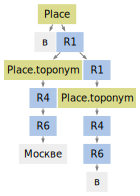

In [23]:
parser = Parser(BIRTH_PLACE)
for text in ["Юрий Яковлев родился в Москве в 1928 году"]:
    for match in parser.findall(text):
        print(text)
        print([_.value for _ in match.tokens])
        print(match.fact)
        display(match.tree.as_dot)
    print()

Из экспериментов понял, что "в" почему-то распознается как аббревиатура. Уберём её

Юрий Яковлев родился в Москве в 1928 году
['в', 'Москве']
Place(toponym=['Москве'])


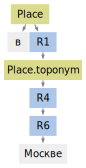

In [24]:

BIRTH_PLACE_FULL = rule(
    BIRTH_PLACE_TAG.optional().repeatable(),
    or_(
        rule(is_capitalized()),
        rule(is_capitalized(), "-", is_capitalized())
    ).repeatable(),
    BIRTH_PLACE_TAG.optional().repeatable()
).interpretation(Place.toponym)

BIRTH_PLACE = rule(
    gram("PREP"), # maybe oprional? But check prep in DATE!!!
    BIRTH_PLACE_FULL.repeatable()
).interpretation(Place)

parser = Parser(BIRTH_PLACE)
for text in ["Юрий Яковлев родился в Москве в 1928 году"]:
    for match in parser.findall(text):
        print(text)
        print([_.value for _ in match.tokens])
        print(match.fact)
        display(match.tree.as_dot)
    print()

Проверим с именем вместе. Зодно будем убирать скобочки сразу.

In [25]:

S = rule(
    NAME.interpretation(Entry.name),
    BIRTH_VERB,
    BIRTH_PLACE.optional().interpretation(Entry.birth_place)
).interpretation(Entry)

parser = Parser(S)

for text in texts:
    text = re.sub(r'\(.*?\)', '', text)
    print(text)
    for match in parser.findall(text):
        # print([_.value for _ in match.tokens])
        print(match.fact)
        # display(match.tree.as_dot)
    print()

Луи родился в зоопарке 22 июля 2013 года.

Блю Айви Картер родилась 7 января в Нью-Йорке

Ежата Джордж, Александр и Луи родились в зоопарке 22 июля 2013 года.

Энгельбарт родился в 1925 году в США

Игорь Доценко родился в 1953 году в Хмельницкой области Украины.
Entry(name=Name(first='игорь', second=None, last='доценко', patronymic=None), birth_place=None, birth_date=None)

Трэмиел родился в 1928 году в Польше

Иосиф Кобзон родился в городе Часов Яр Донецкой области
Entry(name=Name(first='иосиф', second=None, last='кобзон', patronymic=None), birth_place=Place(toponym=['городе Часов Яр', 'Донецкой области']), birth_date=None)

Дмитрий Чернявский родился в Артемовске 5 марта 1992 года

Юрий Яковлев родился в Москве в 1928 году
Entry(name=Name(first='юрий', second=None, last='яковлев', patronymic=None), birth_place=Place(toponym=['Москве']), birth_date=None)

Миллиардер родился в 1938 году в Лондоне

Орест I  родился в 1950 году во Львове.
Entry(name=Name(first='орест', second=None, last=

Где есть город, правильно определи. Где мешает дата, понятно, пока не видим (только *в Москве в* смущает, надо запомнить)

Плюс не получается применять inflect() к repeatable() fact (ошибка **'RepeatableAttribute' object has no attribute 'inflected'**). Но это можно потом попробовать сделать с помощью кода:
```
import pymorphy2

morph = pymorphy2.MorphAnalyzer()

word = "мылом"
normal_form = morph.parse(word)[0].normal_form

print(normal_form)
```

In [26]:
import pymorphy2

morph = pymorphy2.MorphAnalyzer()

word = "Москве"

normal_form = morph.parse(word)[0].normal_form

print(normal_form)

москва


Теперь дата (по аналогии всё)

In [27]:

DAY = and_(
    gte(1),
    lte(31)
)

MONTHS = dictionary({
    'январь',
    'февраль',
    'март',
    'апрель',
    'мая',
    'июнь',
    'июль',
    'август',
    'сентябрь',
    'октябрь',
    'ноябрь',
    'декабрь'
})


YEAR = and_(
    gte(1),
    lte(2024)
)

YEAR_WORDS = dictionary([
    "г.",
    "год"
])

DATE = or_(
    # only year
    rule(YEAR.interpretation(Date.year), YEAR_WORDS.optional()),
    # day and month and year
    rule(
        DAY.interpretation(Date.day),
        MONTHS.interpretation(Date.month.inflected()),
        YEAR.interpretation(Date.year),
        YEAR_WORDS.optional()
    ),
    # year day month
    rule(
        YEAR.interpretation(Date.year),
        YEAR_WORDS.optional(),
        DAY.interpretation(Date.day),
        MONTHS.interpretation(Date.month.inflected())
    ),
    # only day and month
    rule(
        DAY.interpretation(Date.day),
        MONTHS.interpretation(Date.month.inflected())
    )
)


BIRTH_DATE = rule(
    gram("PREP").optional(),
    DATE
).interpretation(Date)


In [43]:
S = BIRTH_DATE

parser = Parser(S)

for text in texts:
    
    for match in parser.findall(text):
        print(text)
        # print([_.value for _ in match.tokens])
        print(match.fact)
        # display(match.tree.as_dot)
    print()

Луи родился в зоопарке 22 июля 2013 года.
Date(day='22', month='июль', year='2013')

Блю Айви Картер родилась 7 января в Нью-Йорке
Date(day='7', month='январь', year=None)

Ежата Джордж, Александр и Луи родились в зоопарке 22 июля 2013 года.
Date(day='22', month='июль', year='2013')

Энгельбарт родился в 1925 году в США
Date(day=None, month=None, year='1925')

Игорь Доценко родился в 1953 году в Хмельницкой области Украины.
Date(day=None, month=None, year='1953')

Трэмиел родился в 1928 году в Польше
Date(day=None, month=None, year='1928')


Дмитрий Чернявский родился в Артемовске 5 марта 1992 года
Date(day='5', month='март', year='1992')

Юрий Яковлев родился в Москве в 1928 году
Date(day=None, month=None, year='1928')

Миллиардер родился в 1938 году в Лондоне
Date(day=None, month=None, year='1938')

Орест I (он же Орест Федорович Карелин-Романишин-Русин) родился в 1950 году во Львове.
Date(day=None, month=None, year='1950')

Том Роу (полное имя Томас Джон Роу) родился в 1956 году в М

Прекрасно определяем дату. Свяжем всё вместе. 

In [140]:
Entry = fact(
    "Entry",
    ["name", "birth_place", "birth_date"]
)

Name = fact(
    "Name",
    ["first", "second", "last", "patronymic"]
)

Date = fact(
    "Date",
    ["day", "month", "year"]
)

Place = fact(
    "Place",
    [attribute('toponym').repeatable()]
)

FIXED_NAME = rule(
    and_(
        gram("Name"),
        is_capitalized(),
        not_(gram("PREP"))
    )
)


JUST_NAME = rule(
    or_(
        FIXED_NAME,
        rule(
            FIXED_NAME,
            rule(
                "-",  # Сергей-Емеля, Иван-царевич
                is_capitalized()
            ).repeatable()
        )
    )
)

TITULS = dictionary(["I","II","III","IV","V","VI","VII","VIII","IX","XI","XII","XII","XIV","XV"])

PATR = rule(
    gram("Patr")
)

SURNNAME = rule(
    or_(
        gram("Surn").interpretation(Name.last.inflected()),
        TITULS.interpretation(Name.last.inflected()),
    )
)

NAME = rule(
    or_(
        # name is there and maybe surnname with patronymic
        rule(
            JUST_NAME.interpretation(Name.first.inflected()),
            # JUST_NAME.interpretation(Name.second.inflected()).optional().repeatable(),
            SURNNAME,
            PATR.interpretation(Name.patronymic.inflected()).optional()
        ),
        rule(
            SURNNAME,
            # обязательно, иначе будем ловить города всякие, всё, что на большую букву 
            JUST_NAME.interpretation(Name.first.inflected()), 
            # JUST_NAME.interpretation(Name.second.inflected()).optional().repeatable(),
            PATR.interpretation(Name.patronymic.inflected()).optional()
        )
    )
).interpretation(Name)

BIRTH_VERB = morph_pipeline([
    "родился",
    "появился на свет"
])

BIRTH_PLACE_TAG = dictionary([
    "штат",
    "город",
    "столица",
    "деревня",
    "окраина",
    "север",
    "юг",
    "восток",
    "запад",
    "край",
    "область",
    "республика",
    "область",
    "страна",
    "дом",
    "поместье",
    "квартира"
])

BIRTH_PLACE_FULL = rule(
    BIRTH_PLACE_TAG.optional().repeatable(),
    or_(
        rule(is_capitalized()),
        rule(is_capitalized(), "-", is_capitalized())
    ).repeatable(),
    BIRTH_PLACE_TAG.optional().repeatable()
).interpretation(Place.toponym)

BIRTH_PLACE = rule(
    gram("PREP"), # maybe oprional? But check prep in DATE!!!
    BIRTH_PLACE_FULL.repeatable()
).interpretation(Place)

DAY = and_(
    gte(1),
    lte(31)
)

MONTHS = dictionary({
    'январь',
    'февраль',
    'март',
    'апрель',
    'мая',
    'июнь',
    'июль',
    'август',
    'сентябрь',
    'октябрь',
    'ноябрь',
    'декабрь'
})


YEAR = and_(
    gte(1),
    lte(2024)
)

YEAR_WORDS = dictionary([
    "г.",
    "год"
])

DATE = or_(
    # only year
    rule(YEAR.interpretation(Date.year), YEAR_WORDS.optional()),
    # day and month and year
    rule(
        DAY.interpretation(Date.day),
        MONTHS.interpretation(Date.month.inflected()),
        YEAR.interpretation(Date.year),
        YEAR_WORDS.optional()
    ),
    # year day month
    rule(
        YEAR.interpretation(Date.year),
        YEAR_WORDS.optional(),
        DAY.interpretation(Date.day),
        MONTHS.interpretation(Date.month.inflected())
    ),
    # only day and month
    rule(
        DAY.interpretation(Date.day),
        MONTHS.interpretation(Date.month.inflected())
    )
)


BIRTH_DATE = rule(
    gram("PREP").optional(),
    DATE
).interpretation(Date)


['Юрий', 'Яковлев', 'родился', 'в', 'Москве', 'в', '1928', 'году']
Entry(name=Name(first='юрий', second=None, last='яковлев', patronymic=None), birth_place=Place(toponym=['Москве']), birth_date=Date(day=None, month=None, year='1928'))


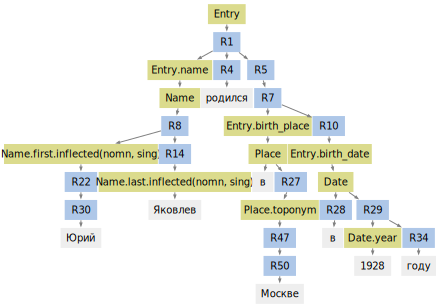

In [34]:

NANE_WITH_BORN = rule(
    NAME.interpretation(Entry.name),
    BIRTH_VERB,
    or_(
        # first place then date
        rule(
            BIRTH_PLACE.interpretation(Entry.birth_place),
            BIRTH_DATE.interpretation(Entry.birth_date).optional()
        ),
        # first date then place
        rule(
            BIRTH_DATE.interpretation(Entry.birth_date),
            BIRTH_PLACE.interpretation(Entry.birth_place).optional()
        )
    ).optional()
)

S = rule(
    or_(
        # only name
        NAME.interpretation(Entry.name),
        # name with born
        NANE_WITH_BORN,
    )
).interpretation(Entry)


text = "Юрий Яковлев родился в Москве в 1928 году"   

parser = Parser(S)
for match in parser.findall(text):
    print([_.value for _ in match.tokens])
    print(match.fact)
    display(match.tree.as_dot)
    
    

In [151]:
import re

texts = [
    "Луи родился в зоопарке 22 июля 2013 года.",
    "Блю Айви Картер родилась 7 января в Нью-Йорке", 
    "Ежата Джордж, Александр и Луи родились в зоопарке 22 июля 2013 года.", 
    "Энгельбарт родился в 1925 году в США",
    "Игорь Доценко родился в 1953 году в Хмельницкой области Украины.",
    "Трэмиел родился в 1928 году в Польше",
    "Иосиф Кобзон родился в городе Часов Яр Донецкой области",
    "Дмитрий Чернявский родился в Артемовске 5 марта 1992 года",
    "Юрий Яковлев родился в Москве в 1928 году",
    "Миллиардер родился в 1938 году в Лондоне",
    "Орест I (он же Орест Федорович Карелин-Романишин-Русин) родился в 1950 году во Львове.",
    "Том Роу (полное имя Томас Джон Роу) родился в 1956 году в Массачусетсе, США.",
    "Головко родился 24 ноября 1932 года в городе Бар (Винницкая область Украины)",
    "Чакляров Георгий Олегович родился 29 апреля 2000 года в Санкт-Петербурге"
]


for text in texts:
    # text = text.replace(",", "")
    text = re.sub(r'\(.*?\)', '', text)
    print(text)
    for match in parser.findall(text):
        print([_.value for _ in match.tokens])
        print(match.fact)
    print()

Луи родился в зоопарке 22 июля 2013 года.

Блю Айви Картер родилась 7 января в Нью-Йорке

Ежата Джордж, Александр и Луи родились в зоопарке 22 июля 2013 года.

Энгельбарт родился в 1925 году в США

Игорь Доценко родился в 1953 году в Хмельницкой области Украины.
Entry(name=Name(first='игорь', second=None, last='доценко', patronymic=None), birth_place=Place(toponym=['Хмельницкой', 'области Украины']), birth_date=Date(day=None, month=None, year='1953'))

Трэмиел родился в 1928 году в Польше

Иосиф Кобзон родился в городе Часов Яр Донецкой области
Entry(name=Name(first='иосиф', second=None, last='кобзон', patronymic=None), birth_place=Place(toponym=['городе Часов Яр', 'Донецкой области']), birth_date=None)

Дмитрий Чернявский родился в Артемовске 5 марта 1992 года

Юрий Яковлев родился в Москве в 1928 году
Entry(name=Name(first='юрий', second=None, last='яковлев', patronymic=None), birth_place=Place(toponym=['Москве']), birth_date=Date(day=None, month=None, year='1928'))

Миллиардер родил

In [154]:
import gzip

from dataclasses import dataclass
from typing import Iterator, Optional

@dataclass
class Text:
    label: str
    title: str
    text: str

@dataclass
class Entry:
    name: str
    birth_date: Optional[str]
    birth_place: Optional[str]


def read_texts(fn: str) -> Iterator[Text]:
    with gzip.open(fn, "rt", encoding="utf-8") as f:
        for line in f:
            yield Text(*line.strip().split("\t"))

texts = list(read_texts("data/news.txt.gz"))

In [155]:
import pymorphy2

morph = pymorphy2.MorphAnalyzer()

def extract_date(date) -> str:
    res = ""
    if date:
        day = date.day if date.day else ''
        month = date.month if date.month else ''
        year = date.year if date.year else ''
        res = f"{day} {month} {year}".strip()
    return res

def extract_name(name) -> str:
    res = ""
    first = name.first if name.first else ''
    second = name.second if name.second else ''
    last = name.last if name.last else ''
    patr = name.patronymic if name.patronymic else ''
    res = f"{last} {first} {second} {patr}".strip()
    return res

def extract_place(place) -> str:
    res = ""
    if place:
        top = place.toponym
        if len(top) == 1:
            top = [morph.parse(top[0])[0].normal_form]
        res = " ".join(top).strip()
    return res


In [156]:
from tqdm import tqdm 
import pandas as pd
import re


def extract_entries(text: list[str]) -> list[Entry]:
    entries = []
    for text in tqdm(text, disable=True):
        # text = text.text.replace(",", "")
        text = re.sub(r'\(.*?\)', '', text.text)
        for match in parser.findall(text):
            entry = match.fact
            print(entry)

            name = extract_name(entry.name)
            birth_date = extract_date(entry.birth_date)
            birth_place = extract_place(entry.birth_place)
            
            entries.append({
                'name': name,
                'birth_date': birth_date,
                'birth_place': birth_place,
            })
    print(f"Amount of entries = {len(entries)}")
    return entries

data = extract_entries(texts)


Entry(name=Name(first='матс', second=None, last='сундин', patronymic=None), birth_place=None, birth_date=None)
Entry(name=Name(first='владимир', second=None, last='филиппов', patronymic=None), birth_place=None, birth_date=None)
Entry(name=Name(first='ильгиз', second=None, last='фахриев', patronymic=None), birth_place=None, birth_date=None)
Entry(name=Name(first='михаил', second=None, last='прохоров', patronymic=None), birth_place=None, birth_date=None)
Entry(name=Name(first='бен', second=None, last='николсон', patronymic=None), birth_place=None, birth_date=None)
Entry(name=Name(first='анри', second=None, last='матисс', patronymic=None), birth_place=None, birth_date=None)
Entry(name=Name(first='пабло', second=None, last='пикассо', patronymic=None), birth_place=None, birth_date=None)
Entry(name=Name(first='жорж', second=None, last='брак', patronymic=None), birth_place=None, birth_date=None)
Entry(name=Name(first='владимир', second=None, last='путин', patronymic=None), birth_place=None, b

In [160]:
df = pd.DataFrame.from_dict(data)
df.head(20)

,name,birth_date,birth_place
0,сундин матс,,
1,филиппов владимир,,
2,фахриев ильгиз,,
3,прохоров михаил,,
4,николсон бен,,
5,матисс анри,,
6,пикассо пабло,,
7,брак жорж,,
8,путин владимир,,
9,брежнев леонид,,


In [161]:
df.describe()

,name,birth_date,birth_place
count,13385,13385,13385
unique,6219,24,15
top,путин владимир,,
freq,451,13361,13367


In [162]:
df1 = df.drop_duplicates()
df1.describe()

,name,birth_date,birth_place
count,6242,6242,6242
unique,6219,24,15
top,васильев борис,,
freq,2,6218,6224


In [171]:
df1.sort_values("birth_date", ascending=False).head(20)

,name,birth_date,birth_place
11070,армстронг олден,5 август 1930,городе вапаконет
8447,самойлов татьяна,4 май 1934,ленинград
11894,серебрякова зинаида,28 июнь 1913,Царском Селе
3375,караченцов николай,27 октябрь 1944,москва
11648,дуров лев,23 декабрь 1931,
9888,васильев борис,21 май 1924,смоленск
12343,жеребцов полина,1985,грозный
4413,титов аня,1984,
5250,сморгонский анатолий,1979,
11603,гришковец евгений,1967,кемерово


In [172]:
df1["birth_place"].unique()

array(['', 'севастополь', 'городе Часов Яр Донецкой области', 'москва',
       'львов', 'Хмельницкой области Украины', 'баку', 'ленинград',
       'хобарт', 'смоленск', 'городе вапаконет', 'кемерово', 'нью-йорк',
       'Царском Селе', 'грозный'], dtype=object)

In [173]:
df1["birth_date"].unique()

array(['', '1928', '27 октябрь 1944', '1950', '1941', '1984', '1841',
       '1953', '1962', '1979', '1917', '4 май 1934', '1938',
       '21 май 1924', '1923', '5 август 1930', '1967', '23 декабрь 1931',
       '1920', '28 июнь 1913', '1933', '1985', '1940', '1877'],
      dtype=object)

In [176]:
df[df['name'].str.contains("яковлев юрий")]

,name,birth_date,birth_place
2447,яковлев юрий,,
2453,яковлев юрий,,
2454,яковлев юрий,,


Почему не сработало:

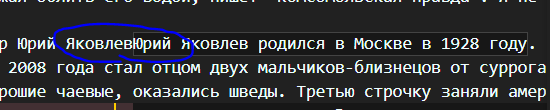